# Övning - Använda Convolutional neural network på katter vs. hundar

I denna övning testar vi en lite mer avancerad uppgift än att klassificera siffror: Vi ska klassificera hundar vs. katter i bilder som inte är lika välpreparerade som MNIST. Eftersom katterna och hundarna har mönster som kan finnas vart som helst i bilden lämpar sig Convolutional neural networks betydligt bättre än vanliga neurala nätverk för denna uppgift!

Övningen är baserad på boken "Deep Learning with Python" av Francois Chollet som även byggt Keras. Rekommenderas för den som vill gräva djupare!

Boken "Deep Learning with Python": https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff

Github med tillhörande notebooks: https://github.com/fchollet/deep-learning-with-python-notebooks



## A. Skapa ett CNN-nätverk

## Data

Vårt dataset kommer från hemsidan Kaggle.com, som 2013 höll en tävling i klassificering av hundar och katter. De bästa bidragen i tävlingen använde CNN-nätverk och hade uppemot 95% accuracy på hela träningsdatat med 25 000 bilder (50% hundar respektive katter). Vi kommer enbart använda oss av 2 000 bilder, dels för att förstå konceptet och se hur väl det går med mindre data, och dels för att minska träningstiden.

Dataset: https://www.kaggle.com/c/dogs-vs-cats/data


Bildurval från datasetet:

![cats_vs_dogs_samples](Bild-exempel-cats-vs-dogs.PNG)

### Mappstruktur

Vi har redan delat upp data i mappar för träning, validering och test

![mappstruktur-cats-vs-dogs](https://github.com/DavidRyden/block5-2020sept/blob/master/mappstruktur-cats-vs-dogs1.PNG?raw=true)

##### Hämta data och hjälpfiler

In [ ]:
!git clone https://github.com/DavidRyden/block5-2020sept.git

In [ ]:
!git clone https://github.com/DavidRyden/block5-cats-dogs.git

In [1]:
# biblioteket os för funktioner relaterade till operativ systemet: peka på filer, skapa mappar etc.
import os 

In [2]:
# Där vi sparar vårt dataset
base_dir = 'block5-cats-dogs/dogs-vs-cats'

# mappar för träning
train_dir = os.path.join(base_dir, 'train')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# mappar för validering
validation_dir = os.path.join(base_dir, 'validation')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# mappar för test
test_dir = os.path.join(base_dir, 'test')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')


Vi verifierar antaler bilder i våra respektive mappar

In [3]:
print('Antal kattbilder, träningsdata:', len(os.listdir(train_cats_dir)))

Antal kattbilder, träningsdata: 1000


In [4]:
print('Antal hundbilder, träningsdata:', len(os.listdir(train_dogs_dir)))

Antal hundbilder, träningsdata: 1000


In [5]:
print('Antal kattbilder, valideringsdata:', len(os.listdir(validation_cats_dir)))

Antal kattbilder, valideringsdata: 500


In [6]:
print('Antal hundbilder, valideringsdata:', len(os.listdir(validation_dogs_dir)))

Antal hundbilder, valideringsdata: 500


In [7]:
print('Antal kattbilder, testdata:', len(os.listdir(test_cats_dir)))

Antal kattbilder, testdata: 500


In [8]:
print('Antal hundbilder, testdata:', len(os.listdir(test_dogs_dir)))

Antal hundbilder, testdata: 500


##### Bildhantering mha ImageDataGenerator

- Det finns flera praktiska fördelar med ImageDataGenerator-biblioteket i Keras vid bildanalys 
- Bland annat laddas enbart antalet bilder angivet i `batch_size` i RAM-minnet, har vi större dataset än RAM-minne kan vi alltså ända träna modellen

Vi börjar med att använda ImageDataGenerator till att:
- Skala om bilderna till rätt storlek (150x150)
- Avkoda våra jpeg bilder till färgkoder (RedBlueGreen)
- Skala om färgkoderna från 0-255 till 0-1, då neurala nätverk konvergerar bättre med små input-värden


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# skalar om färgkoderna fån 0-255 till 0-1
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#Här genererar vi vår input data för träning
train_generator = train_datagen.flow_from_directory(
        # Pekar på var bilderna ligger
        train_dir,
        # alla bilder skalas om till 150x150
        target_size=(150, 150),
        batch_size=20,
        # Då vi använder binary_crossentropy loss, anger vi att vi har binära klasser
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Vår output, `train_generator` och `validation_generator` innehåller våra omformaterade bilder

In [10]:
print("Varje pixel i en bild representeras av tre RGB-värden:", train_generator[0][0][0][0][0])


print("\nVarje bild representeras av 150x150 pixlar, där varje pixel har RGB-värden:", train_generator[0][0][0].shape)

print("\nDessa bilder laddas i batcher om 32:", train_generator[0][0].shape)

print("\n\n Korresponderande Labels till bilderna samlas även de i batcher om 32: ",train_generator[0][1].shape)

print("\n",train_generator.class_indices)

print("\n",train_generator[0][1])


Varje pixel i en bild representeras av tre RGB-värden: [0.5137255  0.50980395 0.32156864]

Varje bild representeras av 150x150 pixlar, där varje pixel har RGB-värden: (150, 150, 3)

Dessa bilder laddas i batcher om 32: (20, 150, 150, 3)


 Korresponderande Labels till bilderna samlas även de i batcher om 32:  (20,)

 {'cats': 0, 'dogs': 1}

 [1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0.]


##### Nätverksarkitektur


Vi skapar här en grundläggande modellarkitektur, likt de vi tidigare gått igenom idag:

- Alternerar mellan Convolutional Neural Networks och Maxpooling-lager

- "Plattar" slutligen till vårt nätverk och kör ett Dense-lager


- I vårt sista output-lager anger vi 1 neuron och "sigmoid" aktivering då vi vill ha prediktioner till vårt binära problem 


In [11]:
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
#32 output filter, (3,3) är höjd och bredd på vårt convolutional window
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1


##### Vidare konfiguration

Vi använder oss av RMSprop som optimizer (ett populärt alternativ till stochastic gradient descent), binary_crossentropy som loss-function samt accuracy som metric

In [12]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])



Vi använder oss av Early stopping
- Om validerings accuracy inte förbättrats de senaste 15 epochs, så slutar vi träna

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

#Early stopping
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=15)


##### Träna nätverket

Vi är nu redo att träna vår modell mha vårt träningsdata (2000 obs) och valideringsdata (1000 obs)

##### "Torrsim"

- Egentligen vill vi här köra 30-50 epochs, men en epoch tar ca 1-2 min. Utan GPU  eller 1h körning på CPU blir vi inte klara med denna träning under vårt övningstillfälle

- Testa att starta nedan och låt den vänta 2-3 min, eller stoppa den mha fyrkanten bredvid "run" 

- Några celler ned laddar vi in en förtränad modell och dess historik för att få ut resultatet av modellträning

In [14]:
history = model.fit(
      train_generator,
    
    # Vi behöver ange steps_per_epoch när vi använder generator
    # steps_per_epoch(100) * batch_size(20) = träningssamples (2000)
      steps_per_epoch=100,
      epochs=1, #30
      validation_data=validation_generator,
      validation_steps=50
      , callbacks=[es]
)

100/100 [==============================] - 350s 3s/step - loss: 0.6900 - acc: 0.5365 - val_loss: 0.6744 - val_acc: 0.6180


Vi sparar ned modellen som vi tränat

In [17]:
model.save('katter_hundar_V1.h5')

In [19]:
# Spara ned träningshistoriken
import pickle
with open('katter_hundar_V1_hist', 'wb') as file_pi:
    #pickle.dump(history.history, file_pi)
    pickle.dump(history.history, file_pi)

##### Ladda in förtränad model

Eftersom att vi inte hinner träna vår modell under vår övningsdag, laddar vi in en förtränad modell och dess historik

In [62]:
from tensorflow.keras.models import load_model
import pickle
 
# Ladda in förtränad model
model = load_model('block5-2020sept/katter_hundar_V1_50_epochs.h5')

# Ladda in historiken för förtränad model

with open('block5-2020sept/katter_hundar_V1_50_epochs_hist', 'rb') as f:
    # load using pickle de-serializer
    history = pickle.load(f)

Hjälpfunktion för att plotta träningshistorik

In [63]:
def plot_training(hist):
    
    print("accuracy, train: ", hist['acc'][-1])
    print("accuracy, validation: ", hist['val_acc'][-1])
    
    # Credd : https://janakiev.com/notebooks/keras-iris/
    # Plot training & validation accuracy values
    plt.plot(hist['acc'])
    plt.plot(hist['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(hist['loss'])
    plt.plot(hist['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

##### Modellutvärdering

- Vi utvärderar nu hur bra modellen tränar på träningsdata och generaliserar på Valideringsdata
- Om det är stor skillnad på modellprestation på träning och valideringsdata så betyder det att vi övertränar


In [64]:
import matplotlib.pyplot as plt

accuracy, train:  0.997
accuracy, validation:  0.725


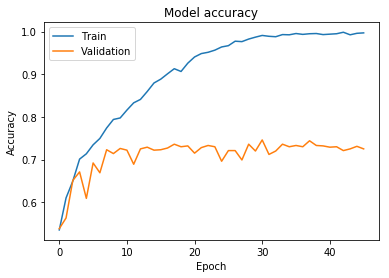

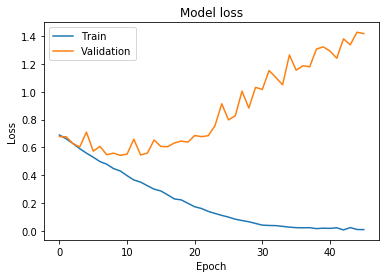

In [65]:
plot_training(history)

- Då vi har relativt lite data att träna på är risken för överträning stor.

- Man kan introducera tekniker så som regularisering, som vi tidigare utforskat
- Inom bildanalys finns dock ännu en teknik för att förbättra generaliseringsförmågan: **data augmentering**


. 

. 

. 

.

## B. Data Augmentering



- Data augmentering innebär att vi slumpmässigt justerar våra input bilder: vänder, vrider, zoomar in
- Detta minskar risken att vårt nätverk övertränar på olika sätt: om vårt input data framförallt är porträttbilder riskerar vi att skapa ett nätverk som ex. inte upptäcker katten om bilden är upp och ned om vi inte använder augmentering. 

Nedan ett par exempel på augmenterings-metoder:

* `rotation_range`, ett värde i grader (0-180) som bilden kan roteras mellan
* `width_shift` och `height_shift`, anges som andel av bildens höjd/bredd som bilden kan förflyttas. En bild med width_shift=0.5 innebär bilden flyttats 50% av sin egen bredd till höger. Man ser då enbart halva orginalbilden och den andra halvan ersätts enligt `fill_mode` 
* `brightness_range` anger mellan vilka värden ljusstyrkan kan justeras: under 1 innebär att bilden görs mörkare, över 1 att den görs ljusare
* `zoom_range` anger slumpmässig inzoomning av bilden.
* `horizontal_flip` True innebär att man slumpmässigt spegelvänder hälften av våra bilder 
* `fill_mode` anger hur vi fyller ut bilden om vissa av våra 150x150 pixlar blir tomma på grund av rotering eller shift. Flyttar vi bilden 50% till höger kommer den vänstra halvan av bilden vara tom. Med fill mode='nearest' anger att vi fyller ut med samma färg som närmast ifyllda pixel.

In [24]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      brightness_range=[0.8,1.2],
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')



Vi tittar på några av våra bilder efter augmentering:

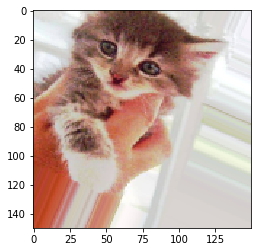

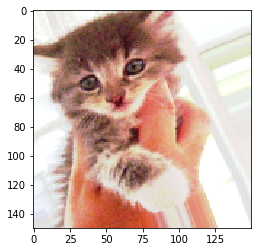

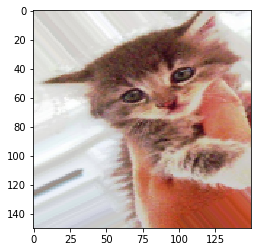

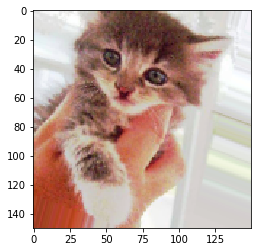

In [25]:
# Bibliotek för bild preprocessing
from tensorflow.keras.preprocessing import image

filenames = [os.path.join(train_cats_dir, filenames) for filenames in os.listdir(train_cats_dir)]

# Vi väljer en av bilderna
img_path = filenames[3]

# Laddar bilden och gör om den till 150x150
img = image.load_img(img_path, target_size=(150, 150))

# Gör om den till en numpy-array
x = image.img_to_array(img)

# Skapar en batch med enbart en bild
x = x.reshape((1,) + x.shape)

# Genererar 4 bilder som är slumpmässigt augmenterade
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()


Med ImageDataGenerator och de augmenteringstekniker vi väljer så ser vår model aldrig exakt samma bild två gånger under träning. Detta förbättrar generaliseringen av vårt nätverk betydligt.


##### Bildhantering och Augmentering mha ImageDataGenerator

Vi skalar återigen bilderna, men introducerar nu även de augmenteringsteknikerna


In [26]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8,1.2],
    zoom_range=0.2,
    horizontal_flip=True,)

# Kom ihåg. Valideringsdata ska inte augmenteras
test_datagen = ImageDataGenerator(rescale=1./255)


#Här genererar vi data för träning
train_generator = train_datagen.flow_from_directory(
        # Pekar på var bilderna ligger
        train_dir,
        # Alla bilder skalas om till 150x150
        target_size=(150, 150),
        batch_size=32,
        # Då vi använder binary_crossentropy loss, anger vi att vi har binära klasser
        class_mode='binary')


#Genererar data för validering
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


##### Nätverksarkitektur


Vi skapar samma modellarkitektur som vi använt ovan:

- Alternerar mellan Convolutional Neural Networks och Maxpooling-lager


- "Plattar" slutligen till vårt nätverk och kör ett Dense-lager


- I vårt sista output-lager anger vi 1 neuron och "sigmoid" aktivering då vi vill ha prediktioner till vårt binära problem 


In [27]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
#model.add(layers.Dropout(0.5)) #Droput är en annan teknik, som vi inte går igenom?
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [28]:
#Early stopping, om validerings accuracy inte förbättrats de senaste 15 epochs, så slutar vi träna
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=15)

##### Träna nätverket

Vi är nu redo att träna nätverket

##### "Torrsim"

- Egentligen vill vi här köra 50-100 epochs, men en epoch tar ca 4-5 min. Utan GPU  eller 1h körning på CPU blir vi inte klara med denna träning under vårt övningstillfälle

- Testa att starta nedan om du vill och låt den vänta 4-5 min, eller stoppa den mha fyrkanten bredvid "run" 

- Några celler ned laddar vi in en förtränad modell och dess histork för att få ut resultatet av modellträning


In [29]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=1, #100
      validation_data=validation_generator,
      validation_steps=50
      #,callbacks=[es]
)

100/100 [==============================] - 463s 5s/step - loss: 0.6895 - acc: 0.5232 - val_loss: 0.6739 - val_acc: 0.5533


Vi sparar ned vår tränade modell - det är alltid bra spara modeller med tanke på tiden det tar att träna

In [30]:
model.save('katter_hundar_V2.h5')

In [31]:
# Spara ned träningshistoriken
with open('katter_hundar_V2_hist', 'wb') as file_pi:
    #pickle.dump(history.history, file_pi)
    pickle.dump(history.history, file_pi)

##### Ladda in förtränad model

Eftersom att vi inte hinner träna vår modell under vår övningsdag, laddar vi in en förtränad modell och dess historik

In [60]:
 
# Ladda in förtränad model
model = load_model('block5-2020sept/katter_hundar_V2_100_epochs.h5')


with open('block5-2020sept/katter_hundar_V2_100_epochs_hist', 'rb') as f:
    # load using pickle de-serializer
    history = pickle.load(f)

##### Modellutvärdering

- Vi utvärderar nu hur bra modellen tränar på träningsdata och generaliserar på Valideringsdata
- Har augmentering förbättrat anpassningen på valideringsdata?


accuracy, train:  0.865846
accuracy, validation:  0.82550764


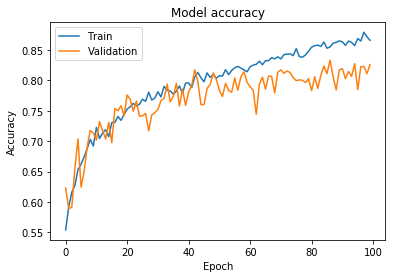

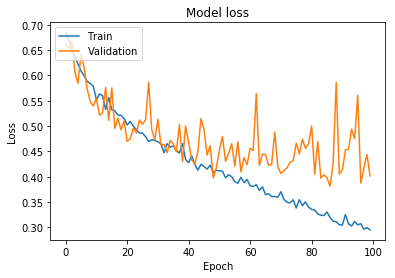

In [61]:
plot_training(history)

Tack vare dataaugmentering har vi ökat accuracy på valideringsdata från 72-73 % upp till 77-78 %.

Risken är dock att vi fortfarande övertränar en del. Genom att optimera parametrar och introducera mer verktyg mot överträning som L2-regularisering och drop-out kan man öka validation accuracy till 86-87%. Det är svårt att nå bättre resultat än så genom bearbetning av modellen, vi kan till slut inte kompensera mer för avsaknad av stora datamängder att träna på.

Vi kan dock använda oss av **förtränade nätverk** för att öka accuracyn ytterligare:
- Dessa nätverk har tränats på flera hundratusen bilder och hittar mönster som sannolikt kan hjälpa oss att klassificera hunder och katter


 .

 .

. 

## C Att använda förtränade Convolutional Neural Networks



- Som vi gått igenom i föreläsningen kan vi utnyttja "transfer learning" med hjälp av förtränade nätverk:

- Vi kommer att använda VGG16 arkitekturen (skapad år 2014) som vi gått igenom i föreläsningen som tränats på ImageNet data (1,4 miljoner bilder och 1000 klasser)
 
- Eftersom ImageNet innehåller många hund och katt-raser är det sannolikt att detta nätverk har lärt sig hitta features som är relevanta även för våra bilder


Det finns två sätt som vi kan använda förtränade CNNer på:

- Feature extraction (Övning 5.3a)
- Fine-tuning (Övning 5.3b)


## C.1 Feature extraction

Vi har ett problem där vi har lite data till hands och en uppgift som är mycket lik den som VGG16 har tränats på.

- Det är därför lämpligt för oss att enbart använda VGG16 convolutional lager och sedan träna ett fully connected-lager på de features som extraherats:

![Transfer learning med lika tasks](Transfer-learning-lika-tasks.PNG)


VGG16 är en av flera förtränade nätverk som finns paketerade i Keras, vi laddar modellen nedan

In [34]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', # Anger VGG16 och vikterna för imagenet
                  include_top=False, # Vi hämtar endast CNN-lager, inte fully connected lagren i "toppen"/slutet av nätverket
                  input_shape=(150, 150, 3))

Så här ser VGG16 ut:

In [35]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

- Efter `block5_pool` kommer vi att addera fully connected lager för att utnyttja den feature engineering som VGG16 har utvunnit
- Notera att output från `block5_pool` är (4, 4, 512), det är denna formen på output som sedan blir input till vår enkla model med fully connected layers


Det mest CPU-effektiva sättet att använda transfer learning med stora nätverk som VGG16 är att helt enkelt köra igenom våra 2000 träningsbilder och 1000 valideringsbilder och ifrån varje bild få ut en output med formen (4, 4, 512) som representerar bilden enligt VGG16

##### Prediktera utifrån VGG16

Nedan kör vi igenom alla batchar med train, validation och test-data

- Notera, vi använder alltså ingen "fit", utan "predict". Vi tränar alltså inte nätverket utan predicerar utifrån nätverket som redan finns

In [37]:
# Laddar in numpy
import numpy as np

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        
        #Notera: det är här vi kör "predict" utifrån vår conv_base
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i % 5 == 0:
            print("batch", i, "klar")
        
        if i * batch_size >= sample_count:
            break
    return features, labels



In [88]:
train_features, train_labels = extract_features(train_dir, 2000)

In [ ]:
validation_features, validation_labels = extract_features(validation_dir, 1000)

Det är valbart om man vill köra igenom testdata nedan - vi kommer inte predicera på det med denna modell

In [ ]:
#test_features, test_labels = extract_features(test_dir, 1000)

De features vi har finns i vår output (samples, 4, 4, 512). Eftersom de nu ska bli input till fully connected neuralt nätverk plattar vi till nätverket så att det får formen `(samples, 8192)`:

In [ ]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
#Valbart att köra igenom test-data nedan
#test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Vi är nu redo att träna nätverket, som går väldigt fort relativt de våra tidigare CNN-näterk

In [34]:

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 4s 2ms/sample - loss: 0.5844 - acc: 0.6915 - val_loss: 0.4279 - val_acc: 0.8240
Epoch 2/30
2000/2000 [==============================] - 3s 2ms/sample - loss: 0.4127 - acc: 0.8170 - val_loss: 0.3454 - val_acc: 0.8680
Epoch 3/30
2000/2000 [==============================] - 3s 2ms/sample - loss: 0.3495 - acc: 0.8520 - val_loss: 0.3228 - val_acc: 0.8610
Epoch 4/30
2000/2000 [==============================] - 3s 2ms/sample - loss: 0.3102 - acc: 0.8710 - val_loss: 0.2885 - val_acc: 0.8950
Epoch 5/30
2000/2000 [==============================] - 3s 2ms/sample - loss: 0.2798 - acc: 0.8860 - val_loss: 0.2853 - val_acc: 0.8820
Epoch 6/30
2000/2000 [==============================] - 3s 2ms/sample - loss: 0.2586 - acc: 0.8915 - val_loss: 0.2650 - val_acc: 0.9020
Epoch 7/30
2000/2000 [==============================] - 3s 2ms/sample - loss: 0.2459 - acc: 0.8995 - val_loss: 0.2575 - val_acc: 0.9010


#### Modellutvärdering

accuracy, train:  0.9735
accuracy, validation:  0.902


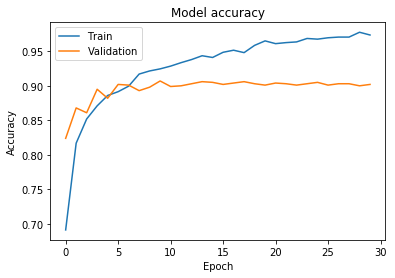

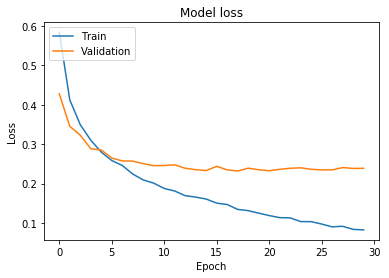

In [35]:
plot_training(history.history)

Vi har nu nått en validation accuracy på på 90%, betydligt bättre än vad vi kan uppnå utan transfer learning!

Notera att vi med ovan metod inte utnyttjade dataaugmentering, vilket innebär att vi fortfarande har möjlighet att förbättra vår modell. Det tog dock mycket tid att använda "predict" på våra 4000 bilder utan augmentering, och det blir betydligt tyngre augmentering. 

Augmentering innebär att varje bild slumpmässigt förändras i varje epoch, för varje epoch vi skulle köra innebär det 4000 nya bilder att köra predict på, en betydligt långsammare process som generellt kräver GPU. Vi går dock igenom vad det innebär att lägga till augmentering i nästa övning om **fine-tuning*


## C.2 Fine-tuning




- När vi nu gått igenom grunderna kring transfer learning fortsätter vi med att:

- Addera data augmentering
- Låsa upp ett fåtal av VGG16 sista lager för att göra vår convolutional bas mer anpassad till vårt problem
- Adderar våra fully connected layers direkt i nätverket, istället för att prediktera och träna i två separata steg


![Transfer learning lika tasks mer data](https://github.com/DavidRyden/block5-2020sept/blob/master/Transfer-learning-lika-tasks-mer-data.PNG?raw=true)

##### Bildhantering och Augmentering mha ImageDataGenerator

Vi skalar återigen bilderna samt använder augmenteringsteknikerna


In [39]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8,1.2],
    zoom_range=0.2,
    horizontal_flip=True,)

# Kom ihåg. Valideringsdata ska inte augmenteras
test_datagen = ImageDataGenerator(rescale=1./255)


#Här genererar vi data för träning
train_generator = train_datagen.flow_from_directory(
        # Pekar på var bilderna ligger
        train_dir,
        # Alla bilder skalas om till 150x150
        target_size=(150, 150),
        batch_size=32,
        # Då vi använder binary_crossentropy loss, anger vi att vi har binära klasser
        class_mode='binary')


#Genererar data för validering
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


##### Modellarkitektur
- Vi skapar nu ett nätverk som börjar med VGG16 och sedan våra Dense-lager

In [40]:
#from tensorflow.keras import models
#from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


##### Frysa VGG16-lager

VGG16-lagren har totalt 14 714 688 parametrar. Merparten av dessa ska tillåter vi inte träning på, vi fryser dessa lager så att vi inte kan uppdatera lagerns vikter. Vi låser dock upp ett fåtal high-level lager för att anpassa dessa bättre till vårt problem.


Vi fine-tunar the 3 sista convolutions-lagren. Alltså ska `block5_conv1`, `block5_conv2` and `block5_conv3` anges som `trainable` = True.


In [41]:
import tensorflow.keras.backend as K
conv_base.trainable = True

print('Antal träningsbara vikter INNAN frysning', np.sum([K.count_params(w) for w in model.trainable_weights]) )



Antal träningsbara vikter INNAN frysning 16812353


In [42]:
# Här anger vi vilka lager som är frysta och inte. block5_conv1 och alla efterföljande sätts som trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [43]:
print('Antal träningsbara vikter EFTER frysning', np.sum([K.count_params(w) for w in model.trainable_weights]) )

Antal träningsbara vikter EFTER frysning 9177089


##### Kompilering

När vi kompilerar sätter vi learning rate (lr) till ett lågt värde: vi vill fine-tuna, och inte råka ta för stora steg som riskerar att förstöra information.

In [44]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

##### Modell checkpoint


- Vid träning av modeller som kräver mycket tid/kraft att träna är det en bra idé att sparar modellen mellan epokerna

- Vi använder Early stopping som tidigare

In [45]:
from tensorflow.keras.callbacks import ModelCheckpoint

#Early stopping
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=15)

# checkpoint
filepath = "saved-model-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint,es]

##### Träning av nätverk

Vi är nu redo att träna vårt nätverk

##### "Torrsim"

- Egentligen vill vi här köra 50-100 epochs, men en epoch tar ca **30-40 min**. Utan GPU  eller 1h körning på CPU blir vi inte klara med denna träning under vårt övningstillfälle

- Testa att starta nedan om du vill och låt den vänta 4-5 min, eller stoppa den mha fyrkanten bredvid "run" 

- Några celler ned laddar vi in en förtränad modell och dess histork för att få ut resultatet av modellträning

In [47]:

history = model.fit(
      train_generator,
      steps_per_epoch=1, #steps per epoch bör egentligen vara 2000 bilder / 20 per batch = 100
      epochs=1, #100
      validation_data=validation_generator,
      validation_steps=1, #validation_steps bör egentligen vara 1000 bilder / 20 per batch = 50
      callbacks=callbacks_list)



Epoch 00001: saving model to saved-model-01-0.69.hdf5
1/1 [==============================] - 68s 68s/step - loss: 0.6828 - acc: 0.5938 - val_loss: 0.6517 - val_acc: 0.6875


Spara ned modellen

In [49]:
model.save('katter_hundar_V3.h5')

In [50]:
# Spara ned träningshistoriken
with open('katter_hundar_V3_hist', 'wb') as file_pi:
    #pickle.dump(history.history, file_pi)
    pickle.dump(history.history, file_pi)

##### Ladda in förtränad model

Eftersom att vi inte hinner träna vår modell under vår övningsdag, laddar vi in en förtränad modell och dess historik

In [1]:
#!pip install --upgrade h5py --user

In [85]:
from tensorflow.keras.models import load_model
import zipfile

#unzippar stor modell
local_zip = 'block5-2020sept/katter_hundar_V3_40_epochs.h5'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('block5-2020sept/')
zip_ref.close()


# Ladda in förtränad model
model = load_model('block5-2020sept/katter_hundar_V3_40_epochs.h5')

# Ladda in historiken för förtränad model
#history = pickle.load(open('katter_hundar_V1_hist'), "rb")

with open('block5-2020sept/katter_hundar_V3_40_epochs_hist', 'rb') as f:
    # load using pickle de-serializer
    history = pickle.load(f)

##### Modellutvärdering

accuracy, train:  0.9789573
accuracy, validation:  0.9162437


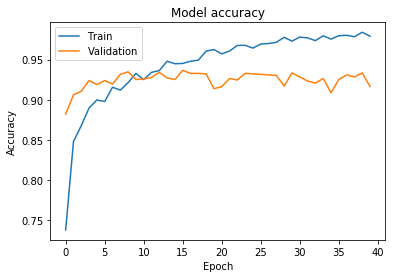

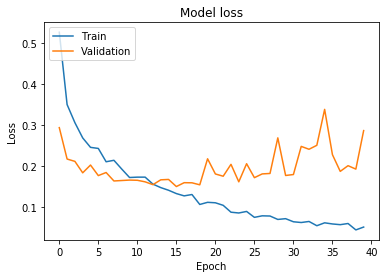

In [86]:
plot_training(history)

Vi uppnår nu 92-93 % validation accuracy med hjälp av finetuning, ännu bättre än feature extraction. 

##### Utvärdera test data

Vi har nu optimerat vår modell en hel del sedan vi gjorde den första modellen med enbart CNN, utan både augmentering och förtränade nätverk. Det är nu dags att utvärdera vår accuracy på test data, som vi överhuvudtaget inte optimerat vår modell för.

In [87]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.93



Vi uppnår nu ett resultat på 93% i test accuracy. När Kaggle-tävling utspelade sig hade detta bidrag varit bland de bättre, och då har vi enbart använt en tiondel av datasetet och istället utnyttjat de framsteg som skett inom deep learning.


#### Slutsats


- Convolutional nätverk fungerar mycket bra för bildanalys, betydligt bättre än fully connected-nätverk

- Överträning på train data är ett vanligt problem. Vi kan mitigera det mha regularisering, drop out och augmentering med gott resultat

- Förtränade nätverk skapar goda förutsättningar för lyckas med image recognition-problem
    - Feature extraction kräver mindre träning och kan ge mycket goda resultat
    - Fine tuning kräver mycket träning, generellt GPUer, men kan ytterligare förbättra resultatet


. 

.

. 